# **Tutorial**

In this notebook, we will work to construct our own graph neural network using PyTorch Geometric (PyG) and then apply that model on  Open Graph Benchmark (OGB) dataset. This dataset will be used to benchmark your model's performance on graph property prediction task: predicting properties of entire graphs or subgraphs.

**Note**: Make sure to **sequentially run all the cells in each section**, so that the intermediate variables / packages will carry over to the next cell

We recommend you to run this notebook in colab so you don't need to go through dependecies installations!

# Device
You might need to use a GPU for this Colab to run quickly.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

# Setup
Installation of PyG on Colab can be a little bit tricky. Firstly, check which version of PyTorch you are running. Copy the version of PyTorch and paste it to the url in the cell below

In [1]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.1.0+cu118


Download the necessary packages for PyG. Make sure that your version of torch matches the output from the cell above. In case of any issues, more information can be found on the [PyG's installation page](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html).

In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.1.0+cu118.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-2.1.0+cu118.html
!pip install torch-geometric
!pip install ogb

# Dataset downloading

In [3]:
import torch_geometric.transforms as T
from ogb.graphproppred import PygGraphPropPredDataset

dataset_name = 'ogbg-molhiv'
# Load the dataset and transform it to sparse tensor
dataset = PygGraphPropPredDataset(name=dataset_name,
                                transform=T.ToSparseTensor())
print('The {} dataset has {} graph'.format(dataset_name, len(dataset)))

# Extract the graph
print("Example of graph:", dataset[0])

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# If you use GPU, the device should be cuda
print('Device: {}'.format(device))

Downloaded 0.00 GB: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]
Processing...


Extracting dataset/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:01<00:00, 33102.96it/s]


Converting graphs into PyG objects...


100%|██████████| 41127/41127 [00:04<00:00, 10120.90it/s]


Saving...


Done!


The ogbg-molhiv dataset has 41127 graph
Example of graph: Data(edge_attr=[40, 3], x=[19, 9], y=[1, 1], num_nodes=19, adj_t=[19, 19, nnz=40])
Device: cuda


# Examples from dataset
1 - Molecule inhibits HIV virus replication. 0 - Not

[0, 0, 0, 1, 1, 0, 0, 0]


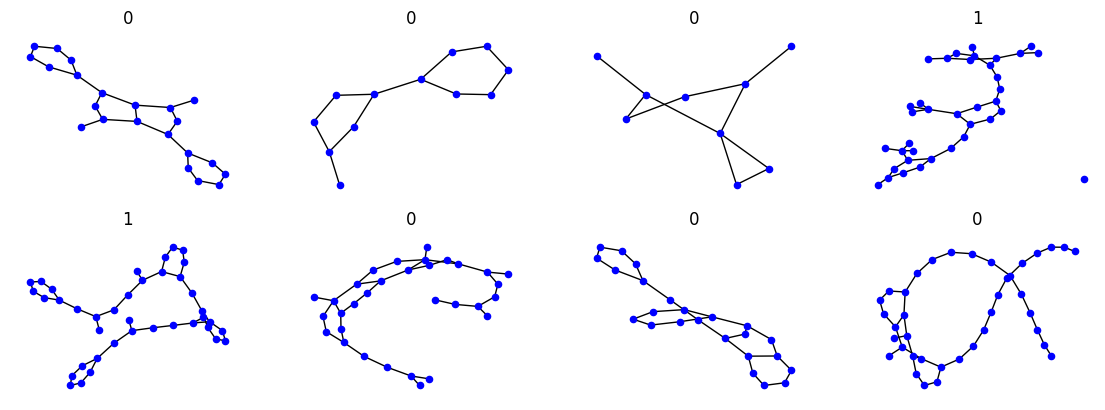

In [93]:
import networkx as nx
import matplotlib.pyplot as plt
import random
plt.rcParams["figure.figsize"] = (14,10)

def visualize_graphs(graphs, labels):
    for i in range(441, 449):
      G=nx.from_numpy_array(graphs[i-441])
      ax = plt.subplot(i)
      ax.set_title(labels[i-441])
      nx.draw(G, node_color='b',node_size=20)
    plt.show()

molecules = random.choices(dataset, k = 8)
graphs = [i["adj_t"].to_dense().numpy() for i in molecules]
labels = [i["y"][0].numpy()[0] for i in molecules]
print(labels)
visualize_graphs(graphs, labels)

# GCN + GraphNorm Model
As our model we will use combination of Graph convolution network and Graph Norm. With that method model converge much faster and achieve better generalization performance.

In [4]:
from torch_geometric.nn.norm import GraphNorm

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout):
        super(GCN, self).__init__()

        # Graph norm layer
        self.graph_norm = GraphNorm(input_dim)

        # A list of GCNConv layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(input_dim, hidden_dim))
        for _ in range(num_layers -2):
          self.convs.append(GCNConv(hidden_dim, hidden_dim))
        self.convs.append(GCNConv(hidden_dim, output_dim))

        # A list of 1D batch normalization layers
        self.bns = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
          self.bns.append(torch.nn.BatchNorm1d(hidden_dim))
        self.dropout = dropout

        # Linear layer
        self.linear = torch.nn.Linear(output_dim, 1)

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()
        self.graph_norm.reset_parameters()

    def forward(self, x, adj_t, batch):

        out = None
        x = self.graph_norm(x, batch)

        for i in range(len(self.convs) - 1):
          x = self.convs[i](x, adj_t)
          x = self.bns[i](x)
          x = F.relu(x)
          x = F.dropout(x, self.dropout, training=self.training)
        x = self.convs[len(self.convs) - 1](x, adj_t)

        x = global_mean_pool(x, batch)
        x = self.linear(x)
        out = x

        return out

# Training arguments

In [30]:
import torch
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import numpy as np
from torch_geometric.nn.pool import global_mean_pool
from tqdm import tqdm

split_idx = dataset.get_idx_split()
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=64, shuffle=False)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=64, shuffle=False)

args = {
      'device': device,
      'num_layers': 5,
      'hidden_dim': 1024,
      'dropout': 0.2,
      'lr': 0.005,
      'epochs': 45,
      "out_channels": 128,
  }

model = GCN(dataset.num_node_features, args['hidden_dim'],
            args["out_channels"], args['num_layers'],
            args['dropout']).to(device)

# Loss and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Train/eval functions

In [31]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
# Training loop
def train():
  model.train()
  train_loss = []
  for data in tqdm(train_loader, total=len(train_loader)):
      optimizer.zero_grad()
      data = data.to(device)
      data.adj_t = data.adj_t.to_symmetric()
      data.x = data.x.float()
      out = model(data.x, data.adj_t, data.batch)
      loss = criterion(out, data.y.view(-1, 1).to(torch.float32))
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())

  return sum(train_loss)/len(train_loss)

# Evaluation
def evaluate(model, loader, display=False):
  model.eval()
  with torch.no_grad():
      y_true = []
      y_pred = []
      for data in loader:
          data = data.to(device)
          data.x = data.x.float()
          data.adj_t = data.adj_t.to_symmetric()
          out = model(data.x, data.adj_t, data.batch)
          y_true.append(data.y.view(-1).cpu().numpy())
          y_pred.append((out > 0.5).view(-1).cpu().numpy())

  y_true = np.concatenate(y_true)
  y_pred = np.concatenate(y_pred)

  # Evaluate using appropriate metrics (e.g., accuracy, F1 score, ROC AUC)
  if display:
    print(f"ROC AUC Score: {roc_auc_score(y_true, y_pred)}")
    print(f"F1 Score: {f1_score(y_true, y_pred)}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
  else:
    return roc_auc_score(y_true, y_pred)

# Training

In [32]:
import copy
best_model = None
best_valid_roc_auc = 0
for epoch in range(args["epochs"]):
  train_loss = train()
  roc_auc_val = evaluate(model, valid_loader)
  print(f"Epoch #{epoch + 1}. Train Loss: {train_loss}. ROC_AUC_val: {roc_auc_val}")
  if roc_auc_val > best_valid_roc_auc:
    best_valid_roc_auc = roc_auc_val
    best_model = copy.deepcopy(model)

100%|██████████| 515/515 [00:30<00:00, 17.15it/s]


Epoch #1. Train Loss: 0.1732360893408361. ROC_AUC_val: 0.5


100%|██████████| 515/515 [00:27<00:00, 19.02it/s]


Epoch #2. Train Loss: 0.1558360968870156. ROC_AUC_val: 0.5


100%|██████████| 515/515 [00:25<00:00, 20.53it/s]


Epoch #3. Train Loss: 0.15455951833898582. ROC_AUC_val: 0.5


100%|██████████| 515/515 [00:25<00:00, 20.36it/s]


Epoch #4. Train Loss: 0.15156240969606974. ROC_AUC_val: 0.5


100%|██████████| 515/515 [00:25<00:00, 20.23it/s]


Epoch #5. Train Loss: 0.14758515216193152. ROC_AUC_val: 0.5


100%|██████████| 515/515 [00:25<00:00, 20.25it/s]


Epoch #6. Train Loss: 0.14439261311176912. ROC_AUC_val: 0.5


100%|██████████| 515/515 [00:25<00:00, 20.42it/s]


Epoch #7. Train Loss: 0.14257688249271472. ROC_AUC_val: 0.5


100%|██████████| 515/515 [00:25<00:00, 20.55it/s]


Epoch #8. Train Loss: 0.14010270839032618. ROC_AUC_val: 0.5178984788359788


100%|██████████| 515/515 [00:25<00:00, 20.20it/s]


Epoch #9. Train Loss: 0.1403826916029731. ROC_AUC_val: 0.49987599206349204


100%|██████████| 515/515 [00:25<00:00, 20.51it/s]


Epoch #10. Train Loss: 0.13752084784209728. ROC_AUC_val: 0.5


100%|██████████| 515/515 [00:25<00:00, 20.33it/s]


Epoch #11. Train Loss: 0.13465864767582672. ROC_AUC_val: 0.5


100%|██████████| 515/515 [00:25<00:00, 20.46it/s]


Epoch #12. Train Loss: 0.13099653404929396. ROC_AUC_val: 0.5876322751322752


100%|██████████| 515/515 [00:25<00:00, 20.04it/s]


Epoch #13. Train Loss: 0.1310313974009845. ROC_AUC_val: 0.5061728395061729


100%|██████████| 515/515 [00:25<00:00, 19.98it/s]


Epoch #14. Train Loss: 0.12954778296927225. ROC_AUC_val: 0.5123456790123457


100%|██████████| 515/515 [00:25<00:00, 20.47it/s]


Epoch #15. Train Loss: 0.1258263058363668. ROC_AUC_val: 0.6034501763668431


100%|██████████| 515/515 [00:25<00:00, 20.14it/s]


Epoch #16. Train Loss: 0.125962246158748. ROC_AUC_val: 0.5540674603174603


100%|██████████| 515/515 [00:25<00:00, 20.21it/s]


Epoch #17. Train Loss: 0.12304355512436443. ROC_AUC_val: 0.5660411155202821


100%|██████████| 515/515 [00:26<00:00, 19.28it/s]


Epoch #18. Train Loss: 0.12228441284155672. ROC_AUC_val: 0.6220927028218695


100%|██████████| 515/515 [00:25<00:00, 19.96it/s]


Epoch #19. Train Loss: 0.12095664960232753. ROC_AUC_val: 0.5981453924162258


100%|██████████| 515/515 [00:25<00:00, 20.59it/s]


Epoch #20. Train Loss: 0.11963348824132994. ROC_AUC_val: 0.5


100%|██████████| 515/515 [00:25<00:00, 20.28it/s]


Epoch #21. Train Loss: 0.11648138130571946. ROC_AUC_val: 0.6333223104056437


100%|██████████| 515/515 [00:25<00:00, 20.37it/s]


Epoch #22. Train Loss: 0.11669823445596741. ROC_AUC_val: 0.5123456790123457


100%|██████████| 515/515 [00:25<00:00, 20.44it/s]


Epoch #23. Train Loss: 0.11577609051018953. ROC_AUC_val: 0.5427138447971781


100%|██████████| 515/515 [00:25<00:00, 19.99it/s]


Epoch #24. Train Loss: 0.11702194399046667. ROC_AUC_val: 0.6272734788359788


100%|██████████| 515/515 [00:25<00:00, 20.22it/s]


Epoch #25. Train Loss: 0.11493748720843815. ROC_AUC_val: 0.5492587081128748


100%|██████████| 515/515 [00:25<00:00, 20.48it/s]


Epoch #26. Train Loss: 0.11220272232606573. ROC_AUC_val: 0.6099950396825398


100%|██████████| 515/515 [00:25<00:00, 20.42it/s]


Epoch #27. Train Loss: 0.1113324382912042. ROC_AUC_val: 0.5738260582010581


100%|██████████| 515/515 [00:25<00:00, 19.83it/s]


Epoch #28. Train Loss: 0.10991214297133163. ROC_AUC_val: 0.5972773368606702


100%|██████████| 515/515 [00:25<00:00, 20.23it/s]


Epoch #29. Train Loss: 0.10862464625207545. ROC_AUC_val: 0.6223407186948853


100%|██████████| 515/515 [00:25<00:00, 20.42it/s]


Epoch #30. Train Loss: 0.10782893714901892. ROC_AUC_val: 0.6038222001763668


100%|██████████| 515/515 [00:25<00:00, 20.57it/s]


Epoch #31. Train Loss: 0.10812507029894053. ROC_AUC_val: 0.5965332892416225


100%|██████████| 515/515 [00:25<00:00, 20.23it/s]


Epoch #32. Train Loss: 0.10633622974663684. ROC_AUC_val: 0.5851796737213404


100%|██████████| 515/515 [00:26<00:00, 19.61it/s]


Epoch #33. Train Loss: 0.1058675086559746. ROC_AUC_val: 0.6035741843033509


100%|██████████| 515/515 [00:25<00:00, 20.43it/s]


Epoch #34. Train Loss: 0.10369722891092589. ROC_AUC_val: 0.585923721340388


100%|██████████| 515/515 [00:25<00:00, 20.14it/s]


Epoch #35. Train Loss: 0.10528909495299302. ROC_AUC_val: 0.5854276895943562


100%|██████████| 515/515 [00:25<00:00, 20.32it/s]


Epoch #36. Train Loss: 0.10283004908632595. ROC_AUC_val: 0.5304921737213404


100%|██████████| 515/515 [00:25<00:00, 20.42it/s]


Epoch #37. Train Loss: 0.10230829475212444. ROC_AUC_val: 0.5791308421516754


100%|██████████| 515/515 [00:25<00:00, 20.10it/s]


Epoch #38. Train Loss: 0.10237959081180466. ROC_AUC_val: 0.5612323633156967


100%|██████████| 515/515 [00:25<00:00, 20.57it/s]


Epoch #39. Train Loss: 0.10054192408846999. ROC_AUC_val: 0.5797508818342152


100%|██████████| 515/515 [00:26<00:00, 19.70it/s]


Epoch #40. Train Loss: 0.09907132912318684. ROC_AUC_val: 0.6447999338624338


100%|██████████| 515/515 [00:32<00:00, 15.67it/s]


Epoch #41. Train Loss: 0.09988795790676643. ROC_AUC_val: 0.6034501763668431


100%|██████████| 515/515 [00:29<00:00, 17.50it/s]


Epoch #42. Train Loss: 0.09802673821997585. ROC_AUC_val: 0.5674052028218695


100%|██████████| 515/515 [00:26<00:00, 19.41it/s]


Epoch #43. Train Loss: 0.09651117911471904. ROC_AUC_val: 0.5429618606701939


100%|██████████| 515/515 [00:25<00:00, 20.31it/s]


Epoch #44. Train Loss: 0.09634959866717747. ROC_AUC_val: 0.6275214947089948


100%|██████████| 515/515 [00:25<00:00, 20.07it/s]


Epoch #45. Train Loss: 0.09472172342385482. ROC_AUC_val: 0.5365410052910052


In [33]:
print("Performance on validation dataset:")
evaluate(best_model, valid_loader, display=True)
print("\nPerformance on test dataset:")
evaluate(best_model, test_loader, display=True)

Performance on validation dataset:
ROC AUC Score: 0.6447999338624338
F1 Score: 0.3636363636363636
Accuracy: 0.9795769511305616

Performance on test dataset:
ROC AUC Score: 0.5732826049170513
F1 Score: 0.223463687150838
Accuracy: 0.9662047167517627
